# Predicting credit card application approvals

## Motivation

The UCI Machine Learning Repository makes available a [dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) on credit card applications in Japan. The objective is to use this dataset to build a model that predicts whether a credit card application will be approved or rejected based on the available features.

## Setting up the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
plt.style.use('ggplot')

## Reading-in the data

In [3]:
df = pd.read_csv('datasets/cc_approvals.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


As can be seen from our DataFrame's column names, the features in this dataset have been anonimized, but they consist of a mixture of categorical and numerical values. Also note that the target is the last column, where:

- `+` denotes an approved credit card application
- `-` denotes a rejected credit card application

Let's rename these columns and further explore what's in them:

In [4]:
column_names = ['f{}'.format(num) for num in range(1, 16)] + ['target']

df.columns = column_names

In [5]:
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Cleaning the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
f1        690 non-null object
f2        690 non-null object
f3        690 non-null float64
f4        690 non-null object
f5        690 non-null object
f6        690 non-null object
f7        690 non-null object
f8        690 non-null float64
f9        690 non-null object
f10       690 non-null object
f11       690 non-null int64
f12       690 non-null object
f13       690 non-null object
f14       690 non-null object
f15       690 non-null int64
target    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


At first look it seems like there aren't any missing values in our data, but a closer look at each feature shows us that the missing values have actually been encoded with a `?`.

Since this is a fairly small dataset, se can take a look at what's in each column individually:

In [7]:
for col in df.columns:
    
    uniques = df.apply(pd.Series.nunique)
    
    print('\n\nColumn {}  ({} unique values)\n----------\n'.format(col, uniques[col]))
    value_counts = df[col].value_counts(dropna=False)
    
    max_show = 10
    
    if(len(value_counts) > max_show):
        print(value_counts.iloc[:max_show])
        print('\n  ... Capped')
    else:
        print(value_counts)



Column f1  (3 unique values)
----------

b    468
a    210
?     12
Name: f1, dtype: int64


Column f2  (350 unique values)
----------

?        12
22.67     9
20.42     7
19.17     6
25.00     6
18.83     6
20.67     6
22.50     6
23.58     6
24.50     6
Name: f2, dtype: int64

  ... Capped


Column f3  (215 unique values)
----------

1.50    21
0.00    19
3.00    19
2.50    19
1.25    16
0.75    16
0.50    15
5.00    14
4.00    12
1.75    12
Name: f3, dtype: int64

  ... Capped


Column f4  (4 unique values)
----------

u    519
y    163
?      6
l      2
Name: f4, dtype: int64


Column f5  (4 unique values)
----------

g     519
p     163
?       6
gg      2
Name: f5, dtype: int64


Column f6  (15 unique values)
----------

c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
Name: f6, dtype: int64

  ... Capped


Column f7  (10 unique values)
----------

v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6


Let's replace these `?`s with actual `Nan`s:

In [8]:
df = df.replace('?', np.nan)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
f1        678 non-null object
f2        678 non-null object
f3        690 non-null float64
f4        684 non-null object
f5        684 non-null object
f6        681 non-null object
f7        681 non-null object
f8        690 non-null float64
f9        690 non-null object
f10       690 non-null object
f11       690 non-null int64
f12       690 non-null object
f13       690 non-null object
f14       677 non-null object
f15       690 non-null int64
target    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


We can see from the call to `df.info()` that a few of our columns haven't been read-in with the correct dtype. Let's fix this:

In [10]:
categorical_cols = ['f1', 'f4', 'f5', 'f6', 'f7', 'f9', 'f10', 'f12', 'f13', 'f14', 'target']
int_cols = ['f11', 'f15']
float_cols = ['f2', 'f3', 'f8']

numerical_cols = float_cols + int_cols

In [11]:
for col in categorical_cols:
    df[col] = df[col].astype('category')
    
for col in int_cols:
    df[col] = df[col].astype('int')

for col in float_cols:
    df[col] = df[col].astype('float')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
f1        678 non-null category
f2        678 non-null float64
f3        690 non-null float64
f4        684 non-null category
f5        684 non-null category
f6        681 non-null category
f7        681 non-null category
f8        690 non-null float64
f9        690 non-null category
f10       690 non-null category
f11       690 non-null int64
f12       690 non-null category
f13       690 non-null category
f14       677 non-null category
f15       690 non-null int64
target    690 non-null category
dtypes: category(11), float64(3), int64(2)
memory usage: 43.3 KB


We'll deal with these missing values later on. First, let's explore our dataset further.

## Initial exploration

### Numerical columns

Let's look at what information is in the numerical columns:

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


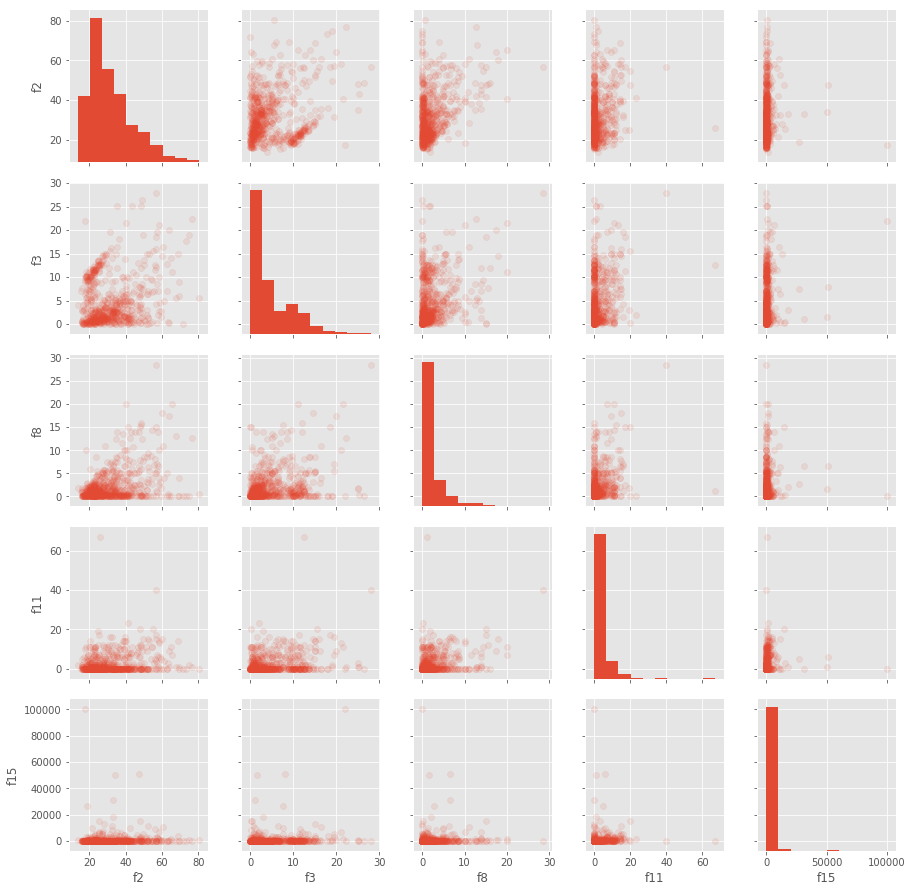

<Figure size 432x288 with 0 Axes>

In [13]:
sns.pairplot(df[numerical_cols],
             plot_kws = {'alpha': 0.1, 'edgecolor': None})
plt.show()
plt.clf()

In [14]:
df[numerical_cols].describe()

,f2,f3,f8,f11,f15
count,678.000000,690.000000,690.000000,690.00000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507
std,11.957862,4.978163,3.346513,4.86294,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,395.500000
max,80.250000,28.000000,28.500000,67.00000,100000.000000


We can see that the range of values in each numerical column differs quite significantly, so we'll have to normalize them later.

This difference in range (particularly for feature `f15`) might be due to the presence of outliers, but since we don't know what each feature actually *is*, I can't tell whether it is actually an outlier, so I'll keep all of the data.

### Categorical columns

Now let's take a look at the columns with categorical data.

I'll start out by plotting, for each feature, the number of observations in each category, separated by whether they were approved (+) or denied (-) a credit card.

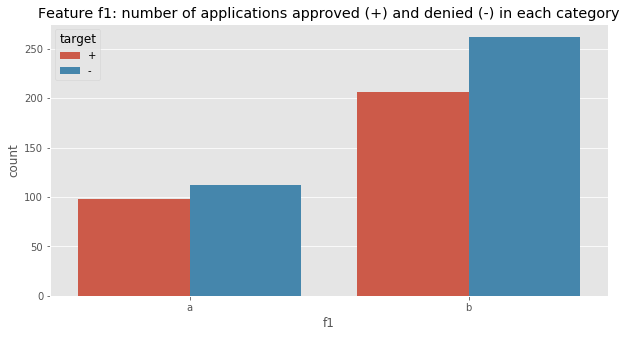

<Figure size 432x288 with 0 Axes>

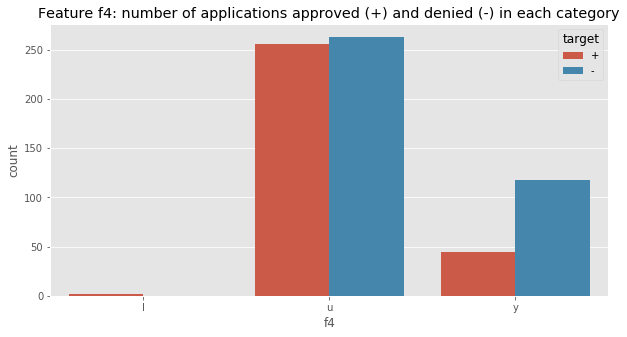

<Figure size 432x288 with 0 Axes>

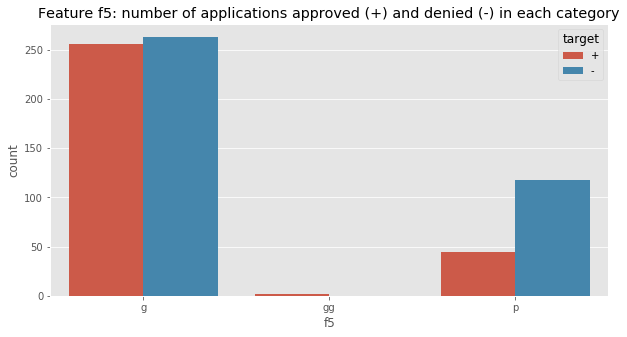

<Figure size 432x288 with 0 Axes>

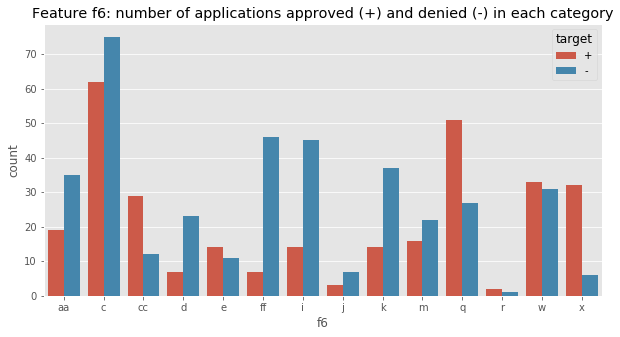

<Figure size 432x288 with 0 Axes>

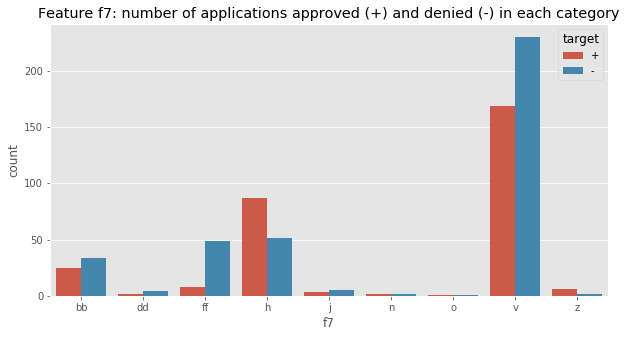

<Figure size 432x288 with 0 Axes>

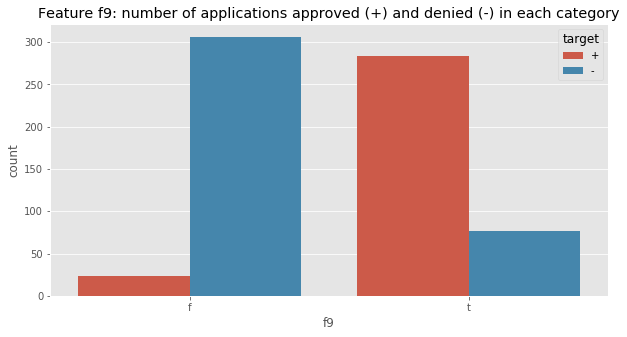

<Figure size 432x288 with 0 Axes>

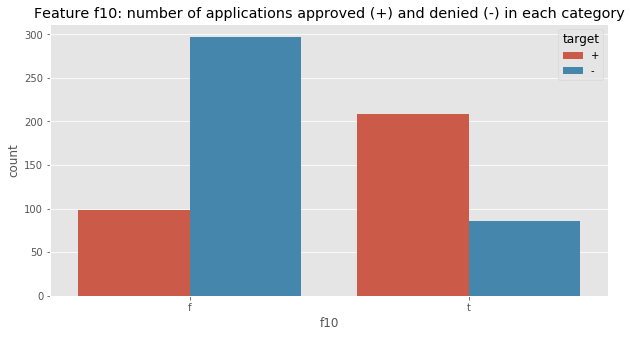

<Figure size 432x288 with 0 Axes>

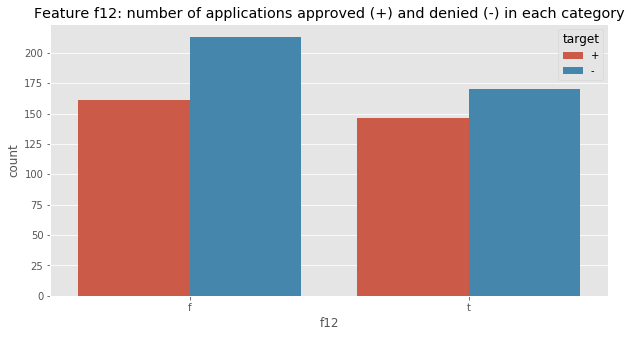

<Figure size 432x288 with 0 Axes>

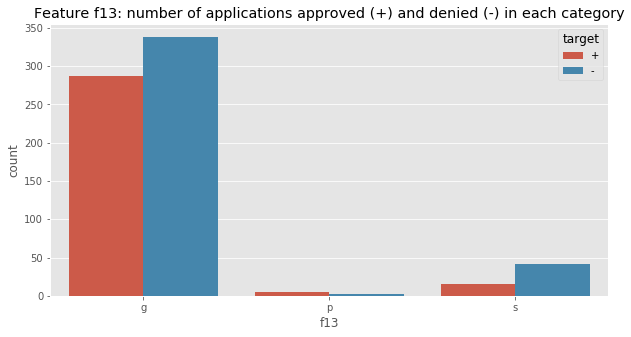

<Figure size 432x288 with 0 Axes>

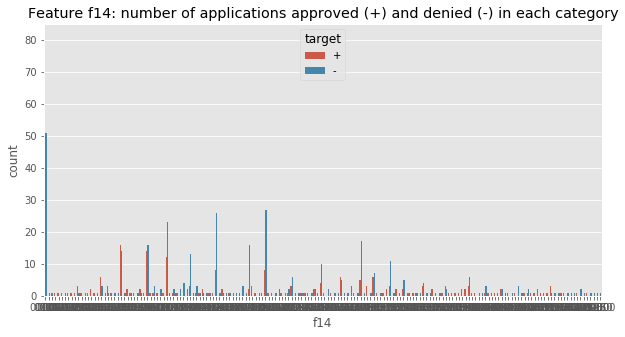

<Figure size 432x288 with 0 Axes>

In [15]:
for cat in categorical_cols[:-1]:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    sns.countplot(x=cat, hue='target', data=df)
    plt.title('Feature ' + cat + ': number of applications approved (+) and denied (-) in each category')
    plt.show()
    plt.clf()

However, simply plotting the number of observations that were approved or denied in each category can be misleading, afterall, a particular category might have many approved applications simply because there are many observations in that category. This makes it difficult to compare the percentage of approvals between categories.

For example, for feature `f13`, we can see from the graph above that there are more observations of category `g` that were denied than of category `s`. But does this mean that an observation of category `g` is more likely to be denied than one of category `s`? Not necessarily. To get a better feel for the answer to questions like this, we can plot, for each feature, the percentage of observations in each category that were approved (+) or denied (-) a credit card:

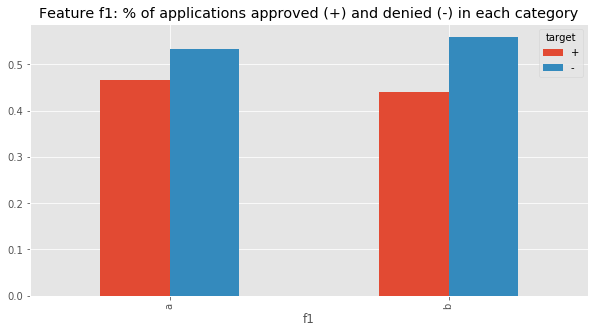

<Figure size 432x288 with 0 Axes>

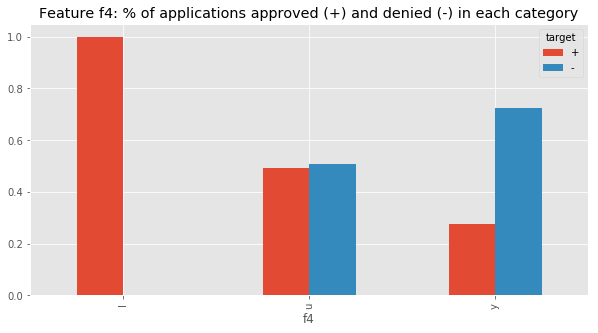

<Figure size 432x288 with 0 Axes>

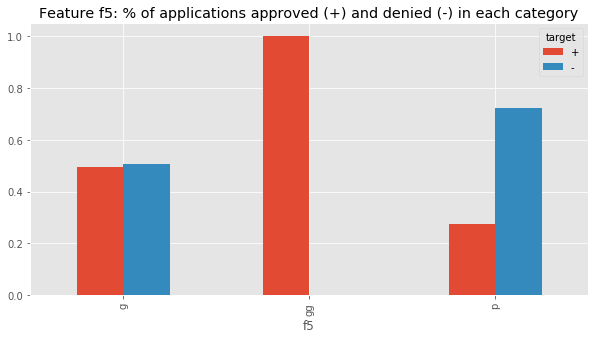

<Figure size 432x288 with 0 Axes>

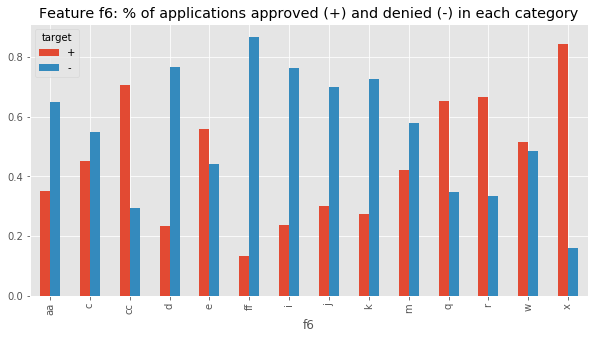

<Figure size 432x288 with 0 Axes>

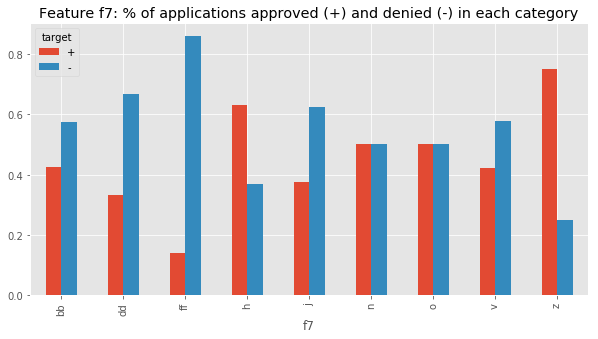

<Figure size 432x288 with 0 Axes>

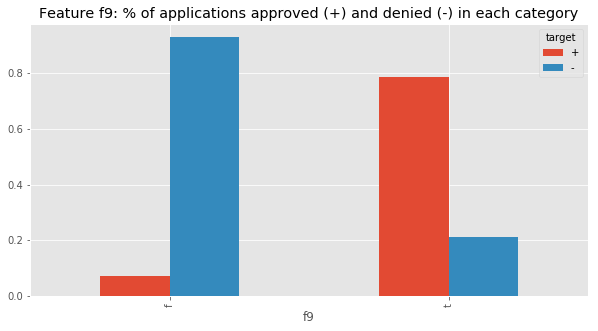

<Figure size 432x288 with 0 Axes>

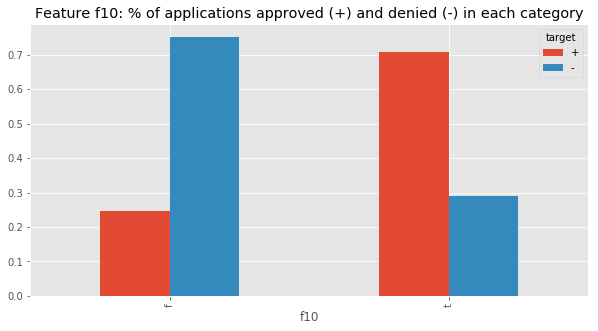

<Figure size 432x288 with 0 Axes>

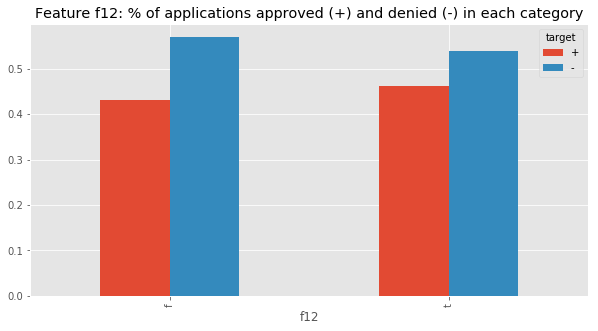

<Figure size 432x288 with 0 Axes>

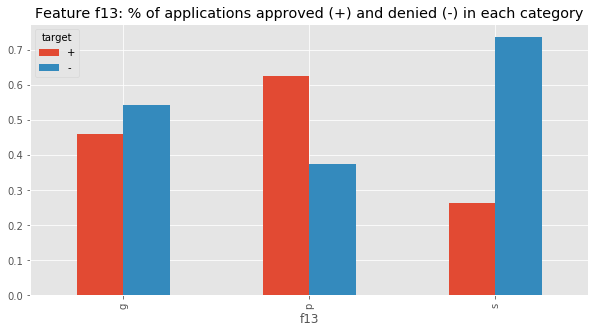

<Figure size 432x288 with 0 Axes>

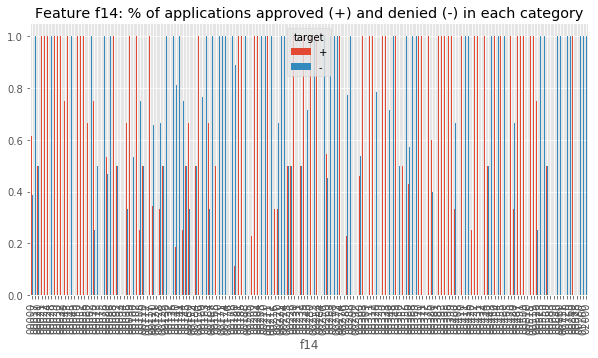

<Figure size 432x288 with 0 Axes>

In [16]:
hue = 'target'

for cat in categorical_cols[:-1]:
    
    counts = df[cat].value_counts()
    percents = pd.pivot_table(df[[cat, hue]], index=[cat], columns=[hue], aggfunc=len)

    for i in percents.index:
        percents.loc[i, :] = percents.loc[i, :]/counts[i]
    
    percents.plot(kind='bar', figsize=(10, 5))
    plt.title('Feature ' + cat + ': % of applications approved (+) and denied (-) in each category')
    plt.show()
    plt.clf()

Now we can clearly tell that, for feature `f13`, an observation of category `s` was denied more than 70% of the time, whereas an observation of category `g` was denied only about 55% of the time.

## Missing values

### Numerical features

As we can see below, of the numerical features, only `f2` has (a small number of) missing values:

In [17]:
df[numerical_cols].isna().sum()

f2     12
f3      0
f8      0
f11     0
f15     0
dtype: int64

We'll impute these with the mean:

In [18]:
df['f2'].fillna(df['f2'].mean(), inplace=True)

df[numerical_cols].isna().sum()

f2     0
f3     0
f8     0
f11    0
f15    0
dtype: int64

### Categorical features

More of the categorical features have missing values, but again, there are relatively few observations with missing values in them:

In [19]:
df[categorical_cols].isna().sum()

f1        12
f4         6
f5         6
f6         9
f7         9
f9         0
f10        0
f12        0
f13        0
f14       13
target     0
dtype: int64

We'll impute these with their most frequent values:

In [20]:
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].value_counts().index[0])
    
df[categorical_cols].isna().sum()

f1        0
f4        0
f5        0
f6        0
f7        0
f9        0
f10       0
f12       0
f13       0
f14       0
target    0
dtype: int64

## Encoding the categorical features

We'll encode these using dummy variables:

In [21]:
df_encoded = pd.DataFrame(index=df.index)

for col in df.columns:
    if(df[col].dtype.name == 'category'):
        right_df = pd.get_dummies(df[col], prefix=col, drop_first=False).iloc[:,:-1]
        df_encoded = df_encoded.join(right_df, how='left', )
        #print(col, df[col].dtype)
    else:
        df_encoded = df_encoded.join(df[col], how='left')

In [22]:
df_encoded.head()

,f1_a,f2,f3,f4_l,f4_u,f5_g,f5_gg,f6_aa,f6_c,f6_cc,...,f14_00680,f14_00711,f14_00720,f14_00760,f14_00840,f14_00928,f14_00980,f14_01160,f15,target_+
0,0,30.83,0.000,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,58.67,4.460,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,560,1
2,1,24.50,0.500,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,824,1
3,0,27.83,1.540,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
4,0,20.17,5.625,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Since feature `f14` has 170 different categories, we end up with an `encoded_df` with over 200 columns.

## Splitting the data into training and testing sets

Now we'll split our data into testing and training sets. Since we don't want any of our test data to be used to scale our training data, we will first split the data and then normalize it.

In [23]:
X, y = df_encoded.iloc[:, :-1], df_encoded.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalizing the features

As mentioned before, since our features have wildly different ranges, we'll need to normalize them. We'll use Scikit-Learn's `MinMaxScaler()` to do this, which will result in features which are scaled between 0 and 1.

In [24]:
scaler = MinMaxScaler()

rescaled_X_train = scaler.fit_transform(X_train)
rescaled_X_test = scaler.fit_transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Fitting a logistic regession model to the data

Predicting whether a credit card application will be approved or denied is a classification task with a binary label. As such, we'll use a simple logistic regression to perform this classification.

In [25]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(rescaled_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

How does our model perform?

In [26]:
print('R2:', logreg.score(rescaled_X_test, y_test))

y_pred = logreg.predict(rescaled_X_test)

conf_mat = confusion_matrix(y_test, y_pred)

print('\nConfusion matrix:\n\n', conf_mat)
print('\nConfusion matrix (%):\n\n', conf_mat/conf_mat.sum())

R2: 0.8260869565217391

Confusion matrix:

 [[57 11]
 [13 57]]

Confusion matrix (%):

 [[0.41304348 0.07971014]
 [0.0942029  0.41304348]]


## Hyperparameter tuning

Now let's see if we can improve our model by tuning a few of its hyperparameters using a grid search.

In [27]:
C = np.logspace(-3, 3, 10)
penalty = ["l1","l2"]

param_grid = dict(C=C, penalty=penalty)

In [28]:
grid_model = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=5)
grid_model_result = grid_model.fit(rescaled_X_train, y_train)

best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.875000 using {'C': 0.021544346900318832, 'penalty': 'l2'}


Now let's see how our tuned model scores on our test data:

In [29]:
print('R2:', grid_model_result.score(rescaled_X_test, y_test))

R2: 0.8478260869565217


As we can see, our model with tuned hyperparameters scores a bit higher than our original model with default parameters.

## Final considerations

An R2 of almost 85% is pretty good, but we could have made it better by:

- Having some idea of what each feature is. We could use this information to, for example, filter out potential outliers. Knowing this also makes our model much more interpretable.
- Testing different classification algorithms.